# Floods Data Ingestion

In this notebook we explore the data sources for WorldFloods. By the end of this notebook you should be able to:
1. Extract flood events from the Copernicus Emergency Management System (EMS)
2. Create composite floodmaps over areas of interest
3. Retrieve Sentinel-2 imagery from Google Earth Engine
4. Layer the floodmap and Sentinel-2 imagery


## Flood Events from Copernicus EMS Activation Mapping

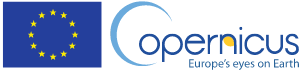

Copernicus EMS provides warnings and risk assessment of floods and other natural disaster through geospatial data derived from satellite imagery. It provides data before, during, and after events in Rapid Mapping format for emergencies and Risk and Recovery format for prevention. In WorldFloods we are primarily interested in the satellite derived imagery with a focus on fluvial, or river, floods.

The Copernicus EMS Activation Mappings for individual events given by unique EMSR codes may be accessed [here]. Linked to each EMSR code per severe event in the Rapid Activations table is the individual webpage for the EMSR code featuring vector zip files from various sources. Each vector zip file may contain multiple products with respect to an event (see below).


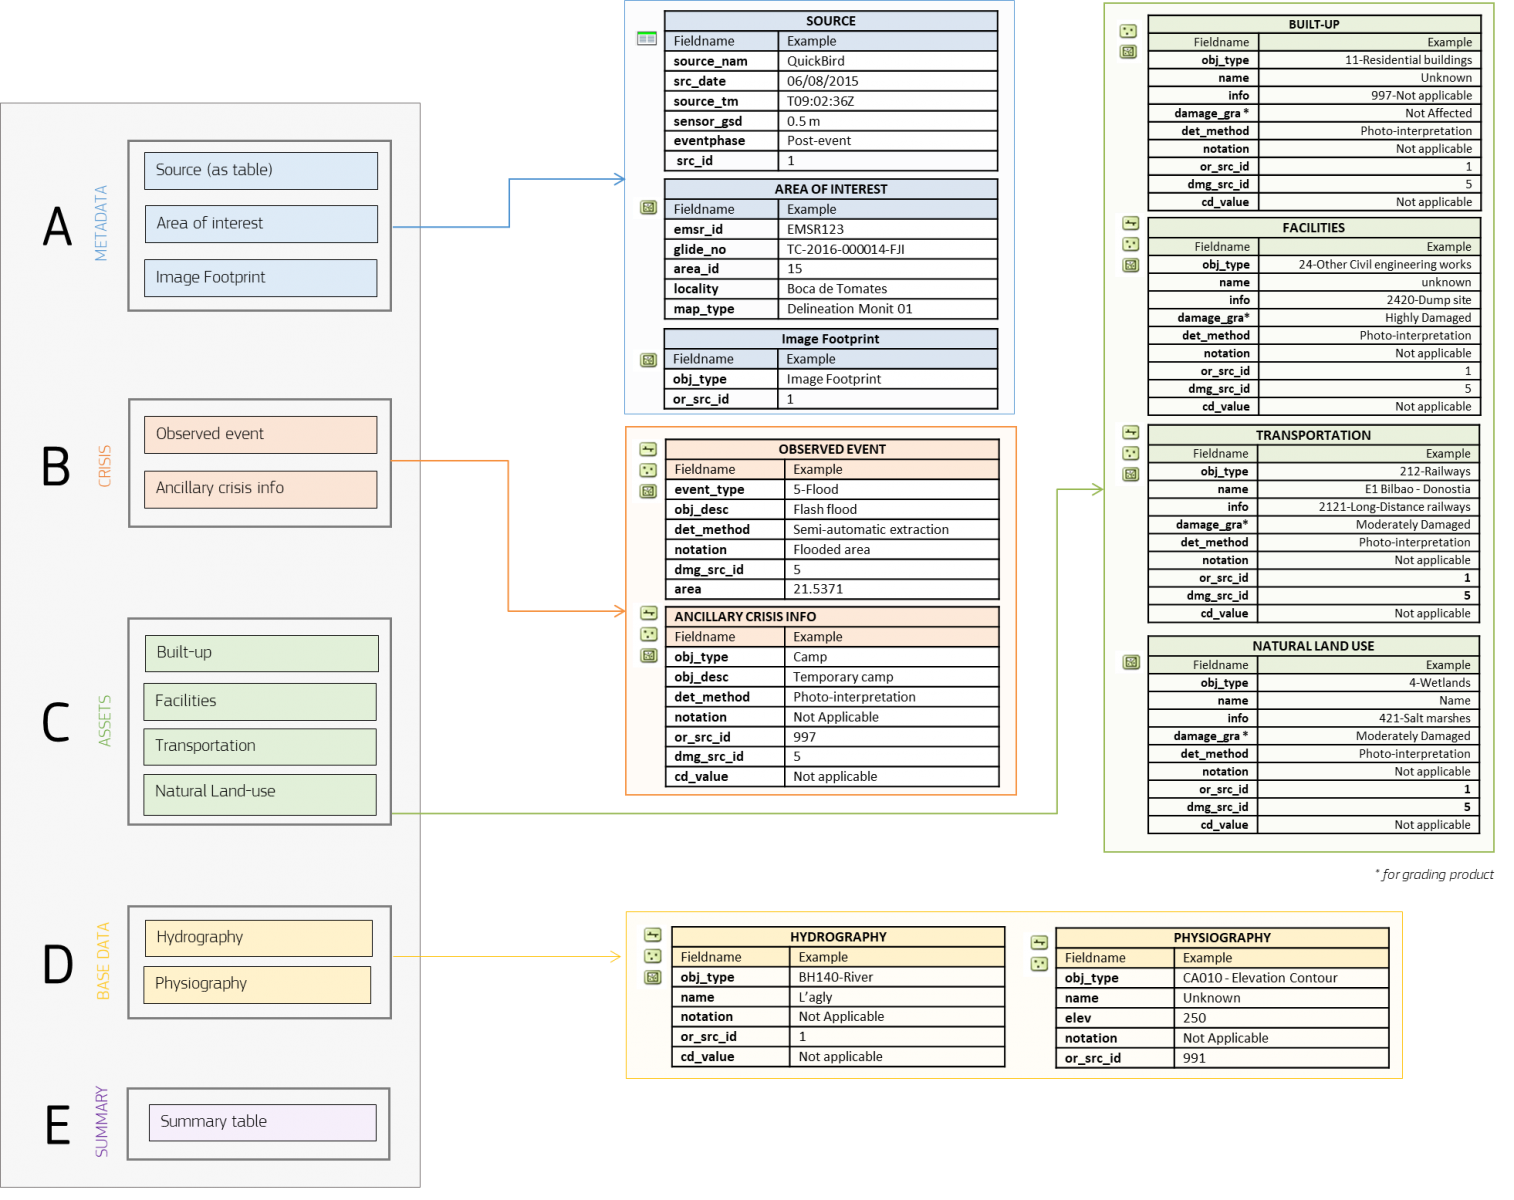!

In WorldFloods we focus on taking advantage of the following EMSR specific data:
- Copernicus EMS Data Source
- The Area of Interest (AOI)
- Observed Event
- Hydrography

With these data we can create a composite floodmask over an AOI to compare with Sentinel-2 images.

### EMSR 486: Flood in Eastern Sardinia

On 27 November 2020 a deep cyclone brought heavy rainfall along Eastern Sardinia, Italy. During this event rivers flooded impacting nearby cities and roadways. We take this event as an example to show how we retrieve and ingest data as an entry point to the preprocessed data used in the WorldFloods machine learning pipeline.

Below is a picture of Eastern Sardinia during normal non-flood conditions.

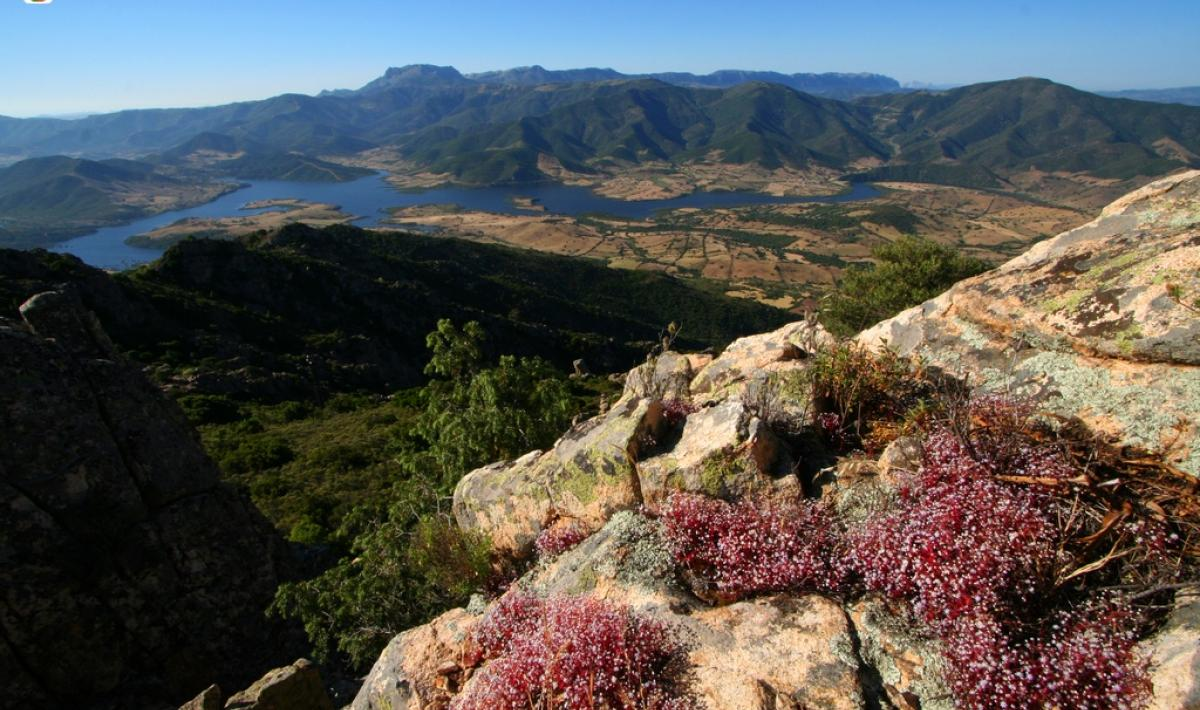

## Retrieve EMSR Flood Event Codes from Copernicus EMS Rapid Mapping

For demonstration purposes, we will fetch the code to get the url of the zipped vector files, then use the urls to download and import EMSR vector zip files to our local machine. First, we will need to import the following modules.

In [1]:
# Path based modules to allow us to save files to our local machine
from pyprojroot import here
import sys
import os
root = here(project_files=[".here"])
sys.path.append(str(here()))

# Geospatial modules and WorldFloods activations mapping module
import geopandas as gpd
from src.data.copernicusEMS import activations

### 1 - Copernicus EMS Rapid Activations Table

We may retrieve a pandas DataFrame format of the [EMS Rapid Activations](https://emergency.copernicus.eu/mapping/list-of-activations-rapid) table using the function <code>table_floods_ems</code> from the activations module in ml4floods/src. In this function you may specify how far back in time you would like to retrieve flood emergency mappings for. Be careful when choosing dates because prior to 23 June 2015 when Sentinel-2 was launched into space.

In [4]:
table_activations_ems = activations.table_floods_ems(event_start_date="2017-01-01")

# The first 5 rows of our table
table_activations_ems.head()

Title    CodeDate   Type  Country
Code                                                                    
EMSR502            Flood in Southern Ireland  2021-02-23  Flood  Ireland
EMSR501                     Flood in Albania  2021-01-06  Flood  Albania
EMSR498  Flood in Corrèze department, France  2021-02-02  Flood   France
EMSR497                     Flood in Germany  2021-02-01  Flood  Germany
EMSR496         Flood in Lazio Region, Italy  2021-01-26  Flood    Italy

### 2 - Retrieve the Zip File URLs for each EMSR Code

The Copernicus EMS Activation Mapping URL location for the November 27th flood event can be fetched using the activation code "EMSR486" and the function <code>fetch_zip_files</code> from <code>activation.py</code> which outputs the url locations as a list of strings. 

In [5]:
activation = "EMSR486"

zip_files_activation = activations.fetch_zip_files(activation)
print(zip_files_activation)

['https://emergency.copernicus.eu/mapping/download/183885/EMSR486_AOI02_DEL_PRODUCT_r1_RTP01_v1_vector.zip', 'https://emergency.copernicus.eu/mapping/download/183886/EMSR486_AOI02_DEL_PRODUCT_r1_VECTORS_v1_vector.zip', 'https://emergency.copernicus.eu/mapping/download/183878/EMSR486_AOI06_GRA_PRODUCT_r1_RTP01_v1_vector.zip', 'https://emergency.copernicus.eu/mapping/download/183879/EMSR486_AOI06_GRA_PRODUCT_r1_VECTORS_v1_vector.zip']


### 3 - Download Vector Shapefiles

<code>download_vector_cems</code> and unzip them in your local directory given by <code>unzip_copernicus_ems</code>.

In [6]:
from tqdm import tqdm

unzip_files_activation = []
for zip_file in tqdm(zip_files_activation):
    local_zip_file = activations.download_vector_cems(zip_file)
    unzipped_file = activations.unzip_copernicus_ems(local_zip_file,
                                                     folder_out=f"copernicusEMS/Copernicus_EMS_raw/{activation}")
    unzip_files_activation.append(unzipped_file)

print(unzip_files_activation)

100%|██████████| 4/4 [00:00<00:00, 521.68it/s]

	File https://emergency.copernicus.eu/mapping/download/183885/EMSR486_AOI02_DEL_PRODUCT_r1_RTP01_v1_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/183886/EMSR486_AOI02_DEL_PRODUCT_r1_VECTORS_v1_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/183878/EMSR486_AOI06_GRA_PRODUCT_r1_RTP01_v1_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/183879/EMSR486_AOI06_GRA_PRODUCT_r1_VECTORS_v1_vector.zip already exists. Not downloaded
['copernicusEMS/Copernicus_EMS_raw/EMSR486/EMSR486_AOI02_DEL_PRODUCT_r1_RTP01_v1_vector', 'copernicusEMS/Copernicus_EMS_raw/EMSR486/EMSR486_AOI02_DEL_PRODUCT_r1_VECTORS_v1_vector', 'copernicusEMS/Copernicus_EMS_raw/EMSR486/EMSR486_AOI06_GRA_PRODUCT_r1_RTP01_v1_vector', 'copernicusEMS/Copernicus_EMS_raw/EMSR486/EMSR486_AOI06_GRA_PRODUCT_r1_VECTORS_v1_vector']


### 4 - Retrieve the Shapefiles Locally as a _register_ Dictionary
We retrieve the .shp files that give the source file, area of interest, observed event, and the hydrography or pre-existing permanent water. The function <code>filter_register_copernicusems</code> returns a dictionary containing pertinent metadata with respect to the shapefiles.

In [8]:
code_date = table_activations_ems.loc[activation]["CodeDate"]

registers = []
for unzip_folder in unzip_files_activation:
    register = activations.filter_register_copernicusems(unzip_folder, code_date)
    registers.append(register)
    print(register["layer name"])


EMSR486_AOI02_DEL_PRODUCT_observedEventA_r1_v1
EMSR486_AOI02_DEL_PRODUCT_observedEventA_r1_v1
EMSR486_AOI06_GRA_PRODUCT_observedEventA_r1_v1
EMSR486_AOI06_GRA_PRODUCT_observedEventA_r1_v1


In [18]:
register

{'event id': 'EMSR486_AOI06_GRA_PRODUCT_r1_VECTORS_v1_vector',
 'layer name': 'EMSR486_AOI06_GRA_PRODUCT_observedEventA_r1_v1',
 'event type': 'Riverine flood',
 'satellite date': Timestamp('2020-12-03 10:01:31+0000', tz='UTC'),
 'country': 'NaN',
 'satellite': 'Pleiades-1A-1B',
 'bounding box': {'west': 9.643201334000025,
  'east': 9.73205387300004,
  'north': 40.64975631800007,
  'south': 40.62699216500005},
 'reference system': {'code space': 'epsg', 'code': '4326'},
 'abstract': 'NaN',
 'purpose': 'NaN',
 'source': 'CopernicusEMS',
 'area_of_interest_polygon': <shapely.geometry.polygon.Polygon at 0x7fd7a257fa60>,
 'observed_event_file': 'copernicusEMS/Copernicus_EMS_raw/EMSR486/EMSR486_AOI06_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR486_AOI06_GRA_PRODUCT_observedEventA_r1_v1.shp',
 'area_of_interest_file': 'copernicusEMS/Copernicus_EMS_raw/EMSR486/EMSR486_AOI06_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR486_AOI06_GRA_PRODUCT_areaOfInterestA_r1_v1.shp',
 'ems_code': 'EMSR486',
 'satellite_pre_

In [13]:
print(register.key)

dict_keys(['event id', 'layer name', 'event type', 'satellite date', 'country', 'satellite', 'bounding box', 'reference system', 'abstract', 'purpose', 'source', 'area_of_interest_polygon', 'observed_event_file', 'area_of_interest_file', 'ems_code', 'satellite_pre_event', 'timestamp_pre_event', 'hydrology_file', 'hydrology_file_l'])


We can explore the key value pairs of the <code>register</code>. For example, we may directly retrieve the AOI polygon over Eastern Sardinia where the flood occurred.

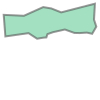

In [19]:
register["area_of_interest_polygon"]

### 5 - <code>generate_floodmap</code>
Generates a composite floodmap polygon based upon the cascaded union of the area of interest polygons for a specific event.

In [20]:
floodmap = activations.generate_floodmap(register, None)
floodmap

geometry           w_class  \
0   MULTIPOLYGON (((9.71259 40.64228, 9.71245 40.6...      Flooded area   
1   MULTIPOLYGON (((9.65320 40.62754, 9.65318 40.6...      Flooded area   
2   POLYGON ((9.64421 40.62988, 9.64411 40.62988, ...      Flooded area   
3   MULTIPOLYGON (((9.70369 40.63643, 9.70363 40.6...      Flooded area   
4   MULTIPOLYGON (((9.69035 40.63546, 9.69030 40.6...      Flooded area   
5   POLYGON ((9.64626 40.63076, 9.64642 40.63059, ...        BH080-Lake   
6   POLYGON ((9.64574 40.62981, 9.64589 40.62979, ...        BH080-Lake   
7   MULTIPOLYGON (((9.64299 40.63710, 9.64281 40.6...       BH140-River   
8   POLYGON ((9.72889 40.63475, 9.72887 40.63475, ...        BH080-Lake   
9   POLYGON ((9.72918 40.63428, 9.72915 40.63414, ...        BH080-Lake   
10  POLYGON ((9.72919 40.63432, 9.72918 40.63428, ...        BH080-Lake   
11  POLYGON ((9.72919 40.63432, 9.72901 40.63435, ...        BH080-Lake   
12  POLYGON ((9.72912 40.63464, 9.72910 40.63464, ...        BH080-Lake   
13  POLYGON ((9.72921 40.63487, 9.72917 40.63487, ...        BH080-Lake   
14  POLYGON ((9.72860 40.63475, 9.72856 40.63474, ...        BH080-Lake   
15  POLYGON ((9.72875 40.63515, 9.72870 40.63496, ...        BH080-Lake   
16  POLYGON ((9.72883 40.63449, 9.72874 40.63419, ...        BH080-Lake   
17  POLYGON ((9.72886 40.63494, 9.72884 40.63494, ...        BH080-Lake   
18  POLYGON ((9.72900 40.63446, 9.72893 40.63417, ...        BH080-Lake   
19  POLYGON ((9.73164 40.62473, 9.73129 40.62411, ...        BH080-Lake   
20  POLYGON ((9.73211 40.65042, 9.73126 40.63468, ...  area_of_interest   

              source  
0              flood  
1              flood  
2              flood  
3              flood  
4              flood  
5              hydro  
6              hydro  
7              hydro  
8              hydro  
9              hydro  
10             hydro  
11             hydro  
12             hydro  
13             hydro  
14             hydro  
15             hydro  
16             hydro  
17             hydro  
18             hydro  
19             hydro  
20  area_of_interest

# Retrieve Sentinel-2 With Google Earth Engine

To retrieve Sentinel-2 images from Google Earth Engine, make sure you create an account and authenticate prior to running the cell below. The link to sign up is [here](https://earthengine.google.com/new_signup/).

To download Sentinel-2 images we will be using the module <code>ee_download</code> and interact with the map using <code>geemap.eefolium</code>.

We use the AOI polygons retrieved from CopernicusEMS to select the location and time that we are interested in and use Google Earth Engine to do the georeferencing. Notice that we may also render the hydrography and observed flood event.

In [24]:
from datetime import timedelta
from datetime import datetime

import ee
from src.data import ee_download
import geemap.eefolium as geemap

from imp import reload
reload(ee_download)

ee.Initialize()

bounds_pol = generate_polygon(register["area_of_interest_polygon"].bounds)
pol_2_clip = ee.Geometry.Polygon(bounds_pol)

# pol with the real area of interest
x, y = register["area_of_interest_polygon"].exterior.coords.xy
pol_list = list(zip(x,y))
pol = ee.Geometry.Polygon(pol_list)

date_event = datetime.utcfromtimestamp(register["satellite date"].timestamp())

date_end_search = date_event + timedelta(days=20)

img_col = ee_download.get_s2_collection(date_event, date_end_search, pol)

n_images_col = img_col.size().getInfo()
print(f"Found {n_images_col} images")
Map = geemap.Map()

imgs_list = img_col.toList(n_images_col, 0)
for i in range(n_images_col):
    img_show = ee.Image(imgs_list.get(i))
    # print(img_show.bandNames().getInfo())
    Map.addLayer(img_show.clip(pol_2_clip), 
                 {"min":0, "max":3000, "bands":["B4","B3","B2"]},f"S2 {i}", True)

geojson_file = "geojson_show.geojson"
floodmap.to_file(geojson_file, driver="GeoJSON")
Map.add_geojson(geojson_file,name="FloodMap")

Map.centerObject(pol)
Map.addLayerControl()
Map

Found 3 images


## Upload Sentinel-2 Images to the Google Cloud Bucket
Use <code>task</code> to monitor the status.

In [22]:
BANDS_EXPORT = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA60', 'probability']

img_export = ee.Image(imgs_list.get(1))

img_export = img_export.select(BANDS_EXPORT).toFloat().clip(pol_2_clip) # .reproject(crs,scale=10).resample('bicubic') resample cannot be used on composites

bucket_name= "ml4floods"

export_task_fun_img = ee_download.export_task_image(bucket=bucket_name)

filename = os.path.join("preingest", "S2", "sardinia")
desc = os.path.basename(filename) + "S2"
task = ee_download.mayberun(filename, desc,
                            lambda : img_export,
                            export_task_fun_img,
                            overwrite=True, dry_run=False,
                            bucket_name=bucket_name, verbose=2)
task.status()

	File preingest/S2/sardinia exists in the bucket. removing


{'state': 'READY',
 'description': 'sardiniaS2',
 'creation_timestamp_ms': 1614319598465,
 'update_timestamp_ms': 1614319598465,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'AGTX6KRNSO4ODZFOPWKP3KVJ',
 'name': 'projects/earthengine-legacy/operations/AGTX6KRNSO4ODZFOPWKP3KVJ'}

## Retrieve Images from Bucket

To demonstrate that the images have been successfully uploaded to the Google Cloud Storage bucket, we open the image using <code>rasterio</code>. 

In [21]:
from src.data import create_gt
import rasterio

image_name = f"gs://{bucket_name}/{filename}.tif"
with rasterio.open(image_name) as src:
    print(src.shape)
    image = src.read()
    transform = src.transform

image.shape

NameError: name 'bucket_name' is not defined

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 10)

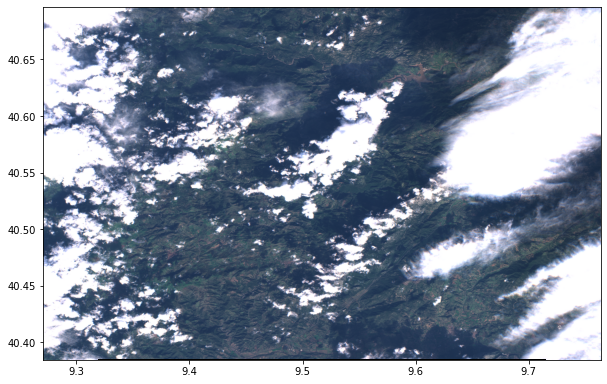

<AxesSubplot:>

In [31]:
from rasterio import plot as rasterioplt
import numpy as np

rgb = np.clip(image[(3,2,1),...]/3000.,0,1)
    
rasterioplt.show(rgb, transform=transform)

## Create Ground Truth Annotated Images
To generate the ground truth images we use the <code>create_gt</code> module. An example of the floodmap image retrieved for the flood in Sardinia, is shown. 

In [32]:
water_mask = create_gt.compute_water(image_name, floodmap)

In [33]:
water_mask.shape,np.unique(water_mask)

((3475, 5490), array([-1,  0,  1,  2], dtype=int16))

In [22]:
plt.imshow(water_mask,vmin=-1, vmax=3)

NameError: name 'plt' is not defined